# Self-Driving Car Engineer Nanodegree

## Project 2: Build a Traffic Sign Recognition Classifier

### By Max Ritter

---
## 0. Load The Data

In [1]:
# Imports
import pickle
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import tensorflow as tf
import math
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import matplotlib.image as mpimg

# Show plots inline notebook
%matplotlib inline

# Location of the dataset
training_file = 'dataset/train.p'
validation_file= 'dataset/valid.p'
testing_file = 'dataset/test.p'

# Open the files
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Save the features and labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("Traffic Sign Dataset loaded!")

Traffic Sign Dataset loaded!


---

## 1. Dataset Summary & Exploration

### Basic Summary of the Data Set Using Numpy

In [2]:
# Number of training examples
n_train = len(y_train)
# Number of validation examples.
n_valid = len(y_valid)
# Number of testing examples.
n_test = len(y_test)

# Shape of a traffic sign image
image_shape = np.shape(X_train[0])

# Unique classes/labels in the dataset
n_classes = len(np.unique(y_train))

# Print out the results
print("Number of training examples = {}".format(n_train))
print ("Number of validation examples = {}".format(n_valid))
print ("Percentage of validation examples: {:2.2f}%".format((n_valid/(n_train*1.0))*100))
print("Number of testing examples = {}".format(n_test))
print("Image data shape = {}".format(image_shape))
print("Number of classes = {}".format(n_classes))

Number of training examples = 34799
Number of validation examples = 4410
Percentage of validation examples: 12.67%
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Print out a table with sign names, class ID and counts for better identification

In [3]:
data_pd = pd.read_csv('dataset/signnames.csv')
_, class_counts = np.unique(y_train, return_counts = True)
data_pd['Counts'] = class_counts
print(data_pd)

    ClassId                                           SignName  Counts
0         0                               Speed limit (20km/h)     180
1         1                               Speed limit (30km/h)    1980
2         2                               Speed limit (50km/h)    2010
3         3                               Speed limit (60km/h)    1260
4         4                               Speed limit (70km/h)    1770
5         5                               Speed limit (80km/h)    1650
6         6                        End of speed limit (80km/h)     360
7         7                              Speed limit (100km/h)    1290
8         8                              Speed limit (120km/h)    1260
9         9                                         No passing    1320
10       10       No passing for vehicles over 3.5 metric tons    1800
11       11              Right-of-way at the next intersection    1170
12       12                                      Priority road    1890
13    

Display 100 random traffic signs, together with their label below

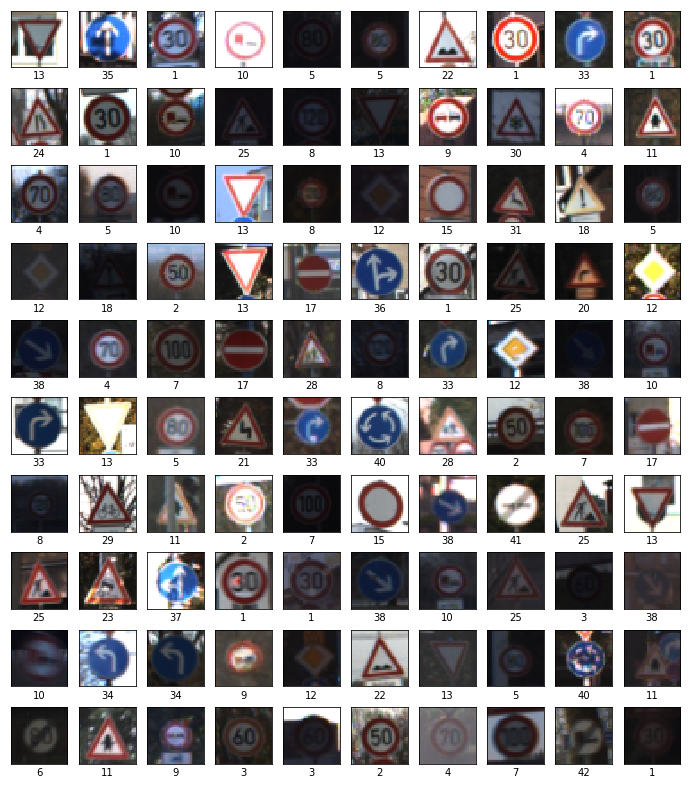

In [4]:
def showRandomImages(gray = False):
    fig = plt.figure(figsize=(12, 14))
    for i in range(0, 100):
        number = np.random.randint(0, len(X_train))
        axis = fig.add_subplot(10,10,i+1)
        axis.set_xlabel(y_train[number])
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if not gray:
            axis.imshow(X_train[number])
        else:
            axis.imshow(X_train[number], cmap='gray')
    plt.show()

showRandomImages()

Show a distribution of the training and testing data in the set, counts per class over class ID

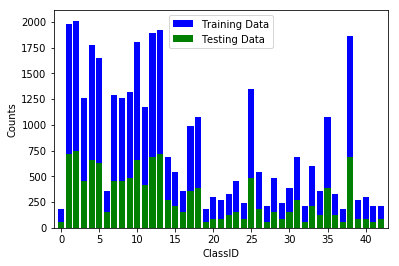

In [6]:
def showDistribution():
    _, training_counts = np.unique(y_train, return_counts = True)
    _, test_counts = np.unique(y_test, return_counts = True)
    plt.bar( np.arange( 43 ), training_counts, align='center',  color='b', label='Training Data')
    plt.bar( np.arange( 43 ), test_counts, align='center', color='g', label='Testing Data')
    plt.xlabel('ClassID')
    plt.ylabel('Counts')
    plt.xlim([-1, 43])
    plt.legend()
    plt.show()
    
showDistribution()

----

## 2. Design and Test a Model Architecture

### Pre-process the Data Set

Do some data augmentation by changing brightness, rotation, translation, transformation and adding random noise

In [6]:
# Change the brightness of an image
def change_brightness(img):
    # Choose random brightness between 50% and 150%
    brightness = np.random.uniform(0.5, 1.5)
    # Convert image to HSV
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    # Bigger numbers to prevent overflow
    img = np.array(img, dtype = np.float64)
    # Multiply with scalar
    img[:,:,2] = img[:,:,2] * brightness
    # Value too big, set to 255
    img[:,:,2][img[:,:,2]>255]  = 255
    # Back to 8-Bit integer
    img = np.array(img, dtype = np.uint8)
    # Back to RGB
    img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    # Return new image
    return img

# Change the rotation of an image
def change_rotation(img, max_rotation):
    # Get image dimensions
    rows, cols = img.shape[:2]
    # Calculate the rotation angle in both directions
    rot_angle = np.random.uniform(-max_rotation, max_rotation)
    # Calculate the rotation matrix
    rot_matrix = cv2.getRotationMatrix2D((cols/2,rows/2), rot_angle, 1)
    # Apply the rotation to the image
    img_rotated = cv2.warpAffine(img, rot_matrix, (cols, rows))
    return img_rotated

# Apply a translation to an image
def change_translation(img, max_trans):
    # Get image dimensions
    rows, cols = img.shape[:2]
    # Calculate random translation (shifting) in x and y direction
    trans_x = np.random.uniform(-max_trans, max_trans)
    trans_y = np.random.uniform(-max_trans, max_trans)
    # Add that to our translation matrix
    trans_matrix = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    # Apply the translation matrix to the image
    img_trans = cv2.warpAffine(img, trans_matrix, (cols, rows))
    return img_trans

# Apply an affine transformation to an image
def change_transformation(img, max_trans):
    # Get image dimensions
    rows, cols = img.shape[:2]
    # Define the starting point
    pts1 = np.float32([[5, 5], [20, 5], [5, 20]])
    # Calculate the random transformation
    trans_p1 = 5 + np.random.uniform(-max_trans, max_trans)
    trans_p2 = 20 + np.random.uniform(-max_trans, max_trans)
    # Define the end point
    pts2 = np.float32([[trans_p1, 5], [trans_p2, trans_p1], [5, trans_p2]])
    # Calculate the affine transformation matrix
    trans_matrix = cv2.getAffineTransform(pts1, pts2)
    # Apply the transformation matrix to the image
    img_trans = cv2.warpAffine(img, trans_matrix, (cols, rows))
    return img_trans

# Apply salt and pepper noise to the image
def add_noise(img, amount):
    # Salt mode
    num_salt = np.ceil(amount * img.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    img[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    img[coords] = 0

    # Return image
    return img

Generate more training samples by using the provided methods above, 3000 samples per class. Takes very long, do only once

In [ ]:
# Store the extended training dataset here
X_train_ext = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = X_train.dtype)
y_train_ext = np.empty([0], dtype = y_train.dtype)

# Position marker
pos = 0

# New class size
class_size_n = 2500

# Get counts per class
_, class_counts = np.unique(y_train, return_counts = True)

# Go through all possible classes and generate additional samples
for c in range(n_classes):
    # First copy existing data for this class
    X_train_ext = np.append(X_train_ext, X_train[y_train == c], axis = 0)
    copied = len(X_train[y_train == c])
    
    # Generate so many samples, that we have 2500 samples at the end per class
    for i in range(class_size_n - class_counts[c]):
        # Pick a random image from that class
        number = np.random.randint(pos, pos + copied)
        image = np.copy(X_train_ext[number])
        
        # Apply one of those four image augmentations randomly
        if (i % 5) == 0:
            image = change_brightness(image)
        elif (i % 5) == 1:
            image = change_rotation(image, 15)
        elif (i % 5) == 2:
            image = change_translation(image, 4)
        elif (i % 5) == 3:
            image = change_transformation(image, 2)
        else:
            image = add_noise(image, 0.01)
            
        # Reshape the image
        image = image.reshape(1, 32, 32, 3)
        
        # Add augmented image to the end of the array
        X_train_ext = np.append(X_train_ext, image, axis = 0)
        
    # Copy current label
    y_train_ext = np.append(y_train_ext, np.full((class_size_n), c, dtype = int))
        
    # Raise position marker
    pos += class_size_n
    
    # Shows message
    print("Finished class {}!".format(c))
    
print("Data augmentation finished!")

Save the extended training dataset in pickle file, do only once

In [ ]:
pickle_file = 'dataset/train_ext.p'
if not os.path.isfile(pickle_file):
    print('Saving extended training data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'features': X_train_ext,
                    'labels': y_train_ext
                },
                pfile, 2)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Extended data training set saved in pickle file!')

Load the extended training set and use it instead of the standard set

In [7]:
pickle_file = 'dataset/train_ext.p'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  X_train = pickle_data['features']
  y_train = pickle_data['labels']
  del pickle_data  # Free up memory

n_train = len(y_train)
print('Extended data training set with {} samples loaded'.format(n_train))

Extended data training set with 107500 samples loaded


Now we convert all the images to grayscale, as the color information is not really required

In [12]:
def convertToGray(image_data):
    image_data = cv2.cvtColor(image_data, cv2.COLOR_RGB2GRAY)
    return image_data

X_train = np.array([convertToGray(X_train[i]) for i in range(len(X_train))])
X_valid = np.array([convertToGray(X_valid[i]) for i in range(len(X_valid))])
X_test = np.array([convertToGray(X_test[i]) for i in range(len(X_test))])
print("Images converted to grayscale!")

Images converted to grayscale!


Explore the data by showing 100 random grayscale images from the extended training set

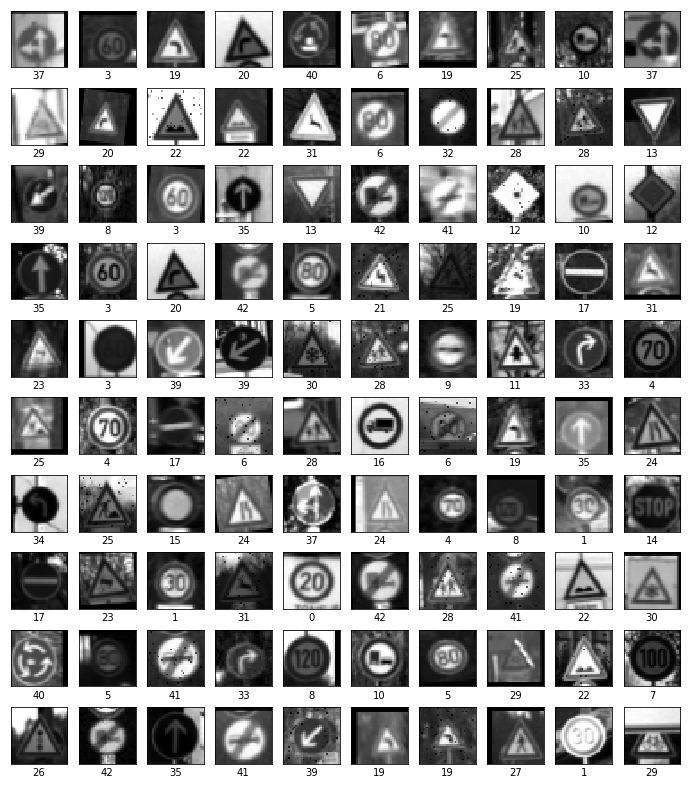

In [9]:
showRandomImages(True)

Show the distribution of the extended set, is equally distributed to 2500 samples per class now

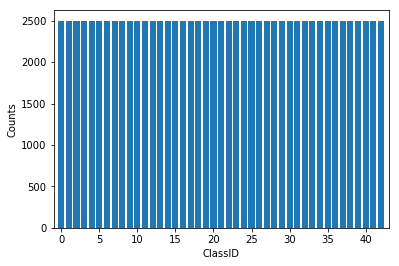

In [10]:
showDistribution()

Apply histogram localization and normalize the data to range 0.0 - 1.0

In [13]:
def normalize(image_data):
    image_data = cv2.equalizeHist(image_data)
    image_data = (image_data / 255.0).astype(np.float32)
    image_data = image_data.reshape(32, 32, 1)
    return image_data

# Check valid length
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

# Normalize training, validation and test data
X_train = np.array([normalize(X_train[i]) for i in range(len(X_train))])
X_valid = np.array([normalize(X_valid[i]) for i in range(len(X_valid))])
X_test = np.array([normalize(X_test[i]) for i in range(len(X_test))])

print("Data normalized!")

Data normalized!


### Model Architecture

Definition of placeholders, the mode and hyper-parameters

In [7]:
# Remove everything from before
tf.reset_default_graph()

# Hyper-parameter to tune
rate = 0.001
epochs = 50
batch_size = 256
keep_prob = 0.5

# Run mode, set to test later
run_mode = "TRAIN"

# Placeholder for input image (32x32x1) and one-hot label (0 .. 42)
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
y_one_hot = tf.one_hot(y, n_classes)

Definition of weights and biases with names for saving

In [8]:
weights = {
    'conv1_w': tf.get_variable('conv1_w', shape=[5, 5, 1, 32], initializer=tf.contrib.layers.xavier_initializer()),
    'conv2_w': tf.get_variable('conv2_w', shape=[5, 5, 32, 64], initializer=tf.contrib.layers.xavier_initializer()),
    'conv3_w': tf.get_variable('conv3_w', shape=[3, 3, 64, 128], initializer=tf.contrib.layers.xavier_initializer()),
    'fc1_w': tf.get_variable('fc1_w', shape=[49 * 128, 256], initializer=tf.contrib.layers.xavier_initializer()),
    'fc2_w': tf.get_variable('fc2_w', shape=[256, 128], initializer=tf.contrib.layers.xavier_initializer()),
    'fc3_w': tf.get_variable('fc3_w', shape=[128, 43], initializer=tf.contrib.layers.xavier_initializer())
}

biases = {
    'conv1_b': tf.Variable(tf.zeros(32), name='conv1_b'),
    'conv2_b': tf.Variable(tf.zeros(64), name='conv2_b'),
    'conv3_b': tf.Variable(tf.zeros(128), name='conv3_b'),
    'fc1_b': tf.Variable(tf.zeros(256), name = 'fc1_b'),
    'fc2_b': tf.Variable(tf.zeros(128), name = 'fc2_b'),
    'fc3_b': tf.Variable(tf.zeros(43), name = 'fc3_b')
}

Definition of the Traffic Sign Net, a modified version of the LeNet-5 architecure with more degrees of freedom

In [9]:
def TrafficSign_Net(x):  
    
    # Layer 1: 1st Convolutional with dropout. Input = 32x32x1. Output = 28x28x32   
    conv1 = tf.nn.conv2d(x, weights['conv1_w'], strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.add(conv1, biases['conv1_b'])
    conv1 = tf.nn.relu(conv1)
    if run_mode is "TRAIN":
        conv1 = tf.nn.dropout(conv1, keep_prob)

    # Layer 2: 2nd Convolutional with max-pool and dropout. Output = 14x14x64
    conv2 = tf.nn.conv2d(conv1, weights['conv2_w'], strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.add(conv2, biases['conv2_b'])
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    if run_mode is "TRAIN":
        conv2 = tf.nn.dropout(conv2, keep_prob)
    
    # Layer 3: 3rd Convolutional with max-pool and dropout. Output = 7x7x128
    conv3 = tf.nn.conv2d(conv2, weights['conv3_w'], strides=[1, 1, 1, 1], padding='SAME')
    conv3 = tf.add(conv3, biases['conv3_b'])
    conv3 = tf.nn.relu(conv3)
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    if run_mode is "TRAIN":
        conv3 = tf.nn.dropout(conv3, keep_prob)
    
    # Flatten
    fc0 = flatten(conv3)
    
    # Layer 4: Fully Connected with Dropout. Input = 6272. Output = 256.
    fc1 = tf.add(tf.matmul(fc0, weights['fc1_w']), biases['fc1_b'])
    fc1 = tf.nn.relu(fc1)
    if run_mode is "TRAIN":
        fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 5: Fully Connected with Dropout. Input = 256. Output = 128.    
    fc2 = tf.add(tf.matmul(fc1, weights['fc2_w']), biases['fc2_b'])
    fc2 = tf.nn.relu(fc2)
    if run_mode is "TRAIN":
        fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 6: Fully Connected. Input = 128. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['fc3_w']), biases['fc3_b'])
    
    return logits

### Train, Validate and Test the Model

Define some stuff to train the network later

In [10]:
# Receive logits from neural network
logits = TrafficSign_Net(x)

# Calculate cross entropy from logits and one-hot labels
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = y_one_hot)

# Calculate training loss
loss = tf.reduce_mean(cross_entropy)

# Use adam as optimizer, better than gradient descent
optimizer = tf.train.AdamOptimizer(learning_rate = rate)

# Define the training operation - minimize the optimizer
training_operation = optimizer.minimize(loss)

# Determine if the predictions are correct
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))

# Calculate the accuracy of the predictions
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Init the saver to save the network after training and define filename
saver = tf.train.Saver()
saver_file = './training/trafficsign.ckpt'

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
epoch_log = []
loss_epoch = []
train_acc_epoch = []
valid_acc_epoch = []

Define an evaluation function to see how well the model performs on the validation set

In [11]:
def evaluate(X_data, y_data):
    # Set total accuracy to zero
    total_accuracy = 0
    # Calculate data length
    data_len = len(X_data)
    # Get the current tensorflow session
    sess = tf.get_default_session()
    
    # Go through the whole validation set in batches
    for offset in range(0, data_len, batch_size):
        # Load a new batch of data
        batch_x, batch_y = X_data[offset : offset+batch_size], y_data[offset : offset+batch_size]
        # Calculate the accuracy for the current batch
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        # Add average to the total accuracy, multiplied by the length of the batch
        total_accuracy += (accuracy * len(batch_x))
    
    # Divide total accuracy through number of examples, to get validation accuracy
    return total_accuracy / data_len

Run the tensorflow training session and display the training results based on the validation set

In [40]:
# Run session
with tf.Session() as session:
    
    # Init the weights and biases
    session.run(tf.global_variables_initializer())
    
    # Calculate the number of batches per epoch
    batch_count = int(math.ceil(n_train / batch_size))

    print("Training {} epochs with {} batches/epoch and {} samples/batch".format(epochs, batch_count, batch_size))
    print()
    
    # Go through the single epochs
    for epoch_n in range(epochs):
        
        # Shuffle training data every epoch
        X_train, y_train = shuffle(X_train, y_train)
        
        # Go through the batches
        for offset in range(0, n_train, batch_size):
            
            # Load a new batch of data
            batch_x, batch_y = X_train[offset : offset+batch_size], y_train[offset : offset+batch_size]
            
            # Run training operation
            _, l = session.run([training_operation, loss], feed_dict={x: batch_x, y: batch_y})
            
        # Show training and validation accuracy for every epoch
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {}:".format(epoch_n))
        print("Training accuracy = {:.3f}".format(training_accuracy))
        print("Validation accuracy = {:.3f}".format(validation_accuracy))
        
         # Log epochs
        previous_epoch = epoch_log[-1] if epoch_log else 0
        epoch_log.append(1 + previous_epoch)
        loss_epoch.append(l)
        train_acc_epoch.append(training_accuracy)
        valid_acc_epoch.append(validation_accuracy)
        
    # Save the model 
    saver.save(session, saver_file)
    print()
    print("Model saved into {}".format(saver_file))

Training 50 epochs with 419 batches/epoch and 256 samples/batch
()
EPOCH 0:
Training accuracy = 0.534
Validation accuracy = 0.526
EPOCH 1:
Training accuracy = 0.741
Validation accuracy = 0.737
EPOCH 2:
Training accuracy = 0.823
Validation accuracy = 0.809
EPOCH 3:
Training accuracy = 0.865
Validation accuracy = 0.866
EPOCH 4:
Training accuracy = 0.890
Validation accuracy = 0.881
EPOCH 5:
Training accuracy = 0.899
Validation accuracy = 0.895
EPOCH 6:
Training accuracy = 0.916
Validation accuracy = 0.905
EPOCH 7:
Training accuracy = 0.927
Validation accuracy = 0.912
EPOCH 8:
Training accuracy = 0.930
Validation accuracy = 0.919
EPOCH 9:
Training accuracy = 0.936
Validation accuracy = 0.923
EPOCH 10:
Training accuracy = 0.944
Validation accuracy = 0.930
EPOCH 11:
Training accuracy = 0.946
Validation accuracy = 0.934
EPOCH 12:
Training accuracy = 0.950
Validation accuracy = 0.934
EPOCH 13:
Training accuracy = 0.953
Validation accuracy = 0.939
EPOCH 14:
Training accuracy = 0.948
Validation 

Create a plot of loss and accuracy over time and show final validation accuracy

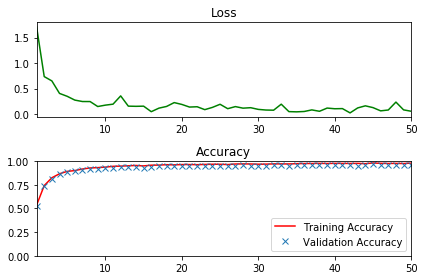

Validation accuracy = 0.958730157973


In [41]:
# Plot loss over time
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(epoch_log, loss_epoch, 'g')
loss_plot.set_xlim([epoch_log[0], epoch_log[-1]])

# Plot accuracy over time
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(epoch_log, train_acc_epoch, 'r', label='Training Accuracy')
acc_plot.plot(epoch_log, valid_acc_epoch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([epoch_log[0], epoch_log[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

# Show validation accuracy
print('Validation accuracy = {}'.format(validation_accuracy))

The last step is to run the model on the test data set

In [14]:
# We switch to test mode, means no dropout any more
run_mode = "TEST"

with tf.Session() as session:
    # Restore trained model
    saver.restore(session, saver_file)
    print("Model restored!")
    
    # Run the test data
    test_accuracy = evaluate(X_test, y_test)
    
    # Print result
    print('Test accuracy  {}'.format(test_accuracy))

Model restored!
Test accuracy  0.9392715757929514


---

## 3. Test a Model on New Images

### Load and Output the Images

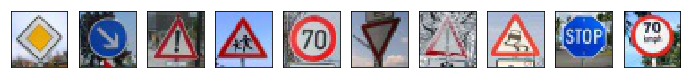

In [109]:
# Name of the five test images
imageNames = ['S1.jpg', 'S2.jpg', 'S3.jpg', 'S4.jpg', 'S5.jpg', 'S6.jpg', 'S7.jpg', 'S8.jpg', 'S9.jpg', 'S10.jpg']

def showTestImages(labels = None):
    fig = plt.figure(figsize=(12, 14))
    for i in range(0, len(imageNames)):
        axis = fig.add_subplot(10,10,i+1)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        
        # Show labels if provided
        if labels is not None:
            axis.set_xlabel(labels[i])
        # Load image from file
        img = mpimg.imread('test_images/' + imageNames[i])
        # Show it
        axis.imshow(img)

    # Show the plot
    plt.show()

showTestImages()

In [110]:
# Store the image pixels here
images = []
for i in range(0, len(imageNames)):
    img = mpimg.imread('test_images/' + imageNames[i])
    images.append(img)
    
# Store the true classes here
true_classes = np.array([12, 38, 18, 28, 4, 13, 18, 23, 14, 4])

# Convert the new images to grayscale
images = np.array([convertToGray(images[i]) for i in range(len(images))])

# Normalize the new images
images = np.array([normalize(images[i]) for i in range(len(images))])
print("Images converted to grayscale and normalized!")

Images converted to grayscale and normalized!


### Predict the Sign Type for Each Image

In [133]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

# Start a tensorflow session
with tf.Session() as session:
    # Restore trained model
    saver.restore(session, saver_file)
    print("Model restored!")

    # Predict new labels and softmax values
    prediction = tf.argmax(logits, 1)
    softmax = tf.nn.softmax(logits)
    predicted_classes, prob_classes = session.run([prediction, softmax], feed_dict={x: images})
    print("Prediction finished!")
    
    # Print out accuracy
    test_accuracy = (np.sum(predicted_classes == true_classes) / len(true_classes)) * 100.0
    print("Test Accuracy: {:2.2f}%".format(test_accuracy))

Model restored!
Prediction finished!
Test Accuracy: 90.00%


### Analyze Performance

Show the test images with their predicted labels

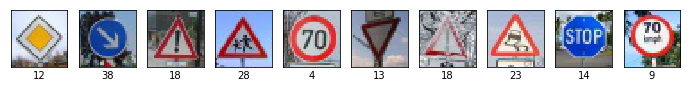

In [134]:
showTestImages(predicted_classes)

Compare what the real classes are

In [135]:
for i in range(0,len(imageNames)):
    print("Image {} - Predicted class =  {}, true class = {}".format(i+1, predicted_classes[i], true_classes[i]))

Image 1 - Predicted class =  12, true class = 12
Image 2 - Predicted class =  38, true class = 38
Image 3 - Predicted class =  18, true class = 18
Image 4 - Predicted class =  28, true class = 28
Image 5 - Predicted class =  4, true class = 4
Image 6 - Predicted class =  13, true class = 13
Image 7 - Predicted class =  18, true class = 18
Image 8 - Predicted class =  23, true class = 23
Image 9 - Predicted class =  14, true class = 14
Image 10 - Predicted class =  9, true class = 4


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

Calculate the softmax probablilites, then get the five maximum values

Print out the estimated classes for each image

In [136]:
for i in range(0,len(imageNames)):
    top_k = tf.nn.top_k(prob_classes[i], k=5)
    indices = top_k.indices.eval(session=tf.Session())
    values = top_k.values.eval(session=tf.Session())
    
    
    print("Image {}:".format(i+1))
    for j in range(0,5):
        print("Class {} with {:3.2f}%".format(indices[j], values[j] * 100.0))
    print()

Image 1:
Class 12 with 100.00%
Class 35 with 0.00%
Class 36 with 0.00%
Class 15 with 0.00%
Class 38 with 0.00%

Image 2:
Class 38 with 100.00%
Class 34 with 0.00%
Class 12 with 0.00%
Class 1 with 0.00%
Class 7 with 0.00%

Image 3:
Class 18 with 100.00%
Class 24 with 0.00%
Class 27 with 0.00%
Class 26 with 0.00%
Class 38 with 0.00%

Image 4:
Class 28 with 100.00%
Class 30 with 0.00%
Class 29 with 0.00%
Class 20 with 0.00%
Class 22 with 0.00%

Image 5:
Class 4 with 100.00%
Class 1 with 0.00%
Class 8 with 0.00%
Class 7 with 0.00%
Class 0 with 0.00%

Image 6:
Class 13 with 100.00%
Class 12 with 0.00%
Class 15 with 0.00%
Class 3 with 0.00%
Class 38 with 0.00%

Image 7:
Class 18 with 99.97%
Class 26 with 0.03%
Class 38 with 0.00%
Class 27 with 0.00%
Class 31 with 0.00%

Image 8:
Class 23 with 99.92%
Class 19 with 0.08%
Class 30 with 0.00%
Class 22 with 0.00%
Class 29 with 0.00%

Image 9:
Class 14 with 100.00%
Class 33 with 0.00%
Class 38 with 0.00%
Class 34 with 0.00%
Class 12 with 0.00%

Im

Show the estimated classes distribution for each image

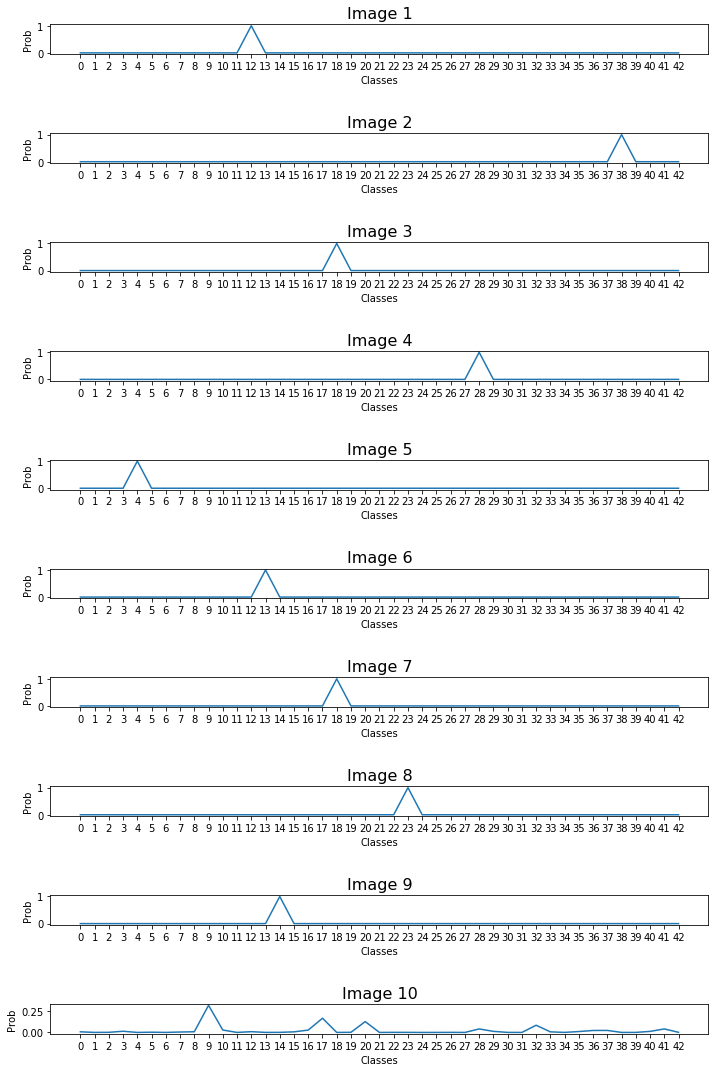

In [137]:
figure = plt.figure(figsize=(10,15))
for i in range(0,len(imageNames)):
    axis = figure.add_subplot(len(imageNames),1,i+1)
    axis.set_xlabel("Classes")
    axis.set_ylabel("Prob")
    axis.set_title("Image {}".format(i+1) , fontsize=16)
    plt.xticks(range(0,43))
    axis.plot(range(0,43),prob_classes[i])

plt.tight_layout(h_pad=3, w_pad=0)    

---

## 4. Visualize the Neural Network's State with Test Images


Model restored!


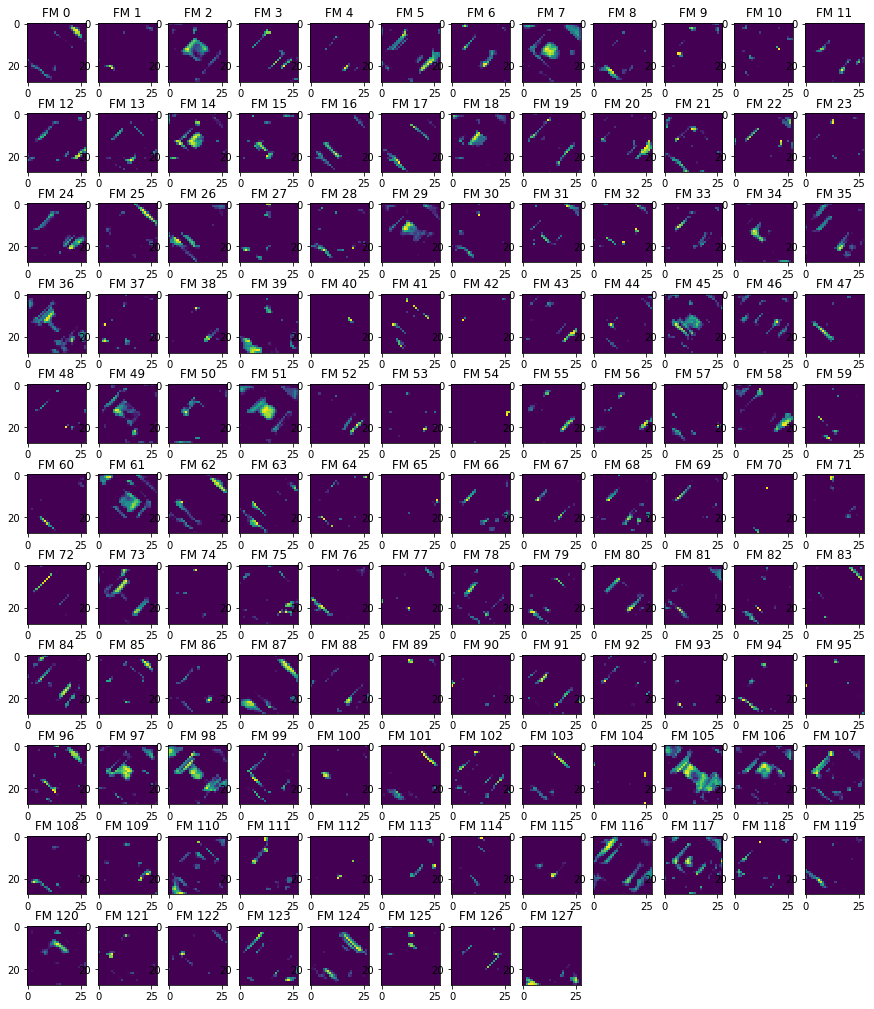

In [68]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=session,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,18))
    for featuremap in range(featuremaps):
        plt.subplot(11,12, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FM ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max)
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max)
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min)
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest")
    
# Layer 1: 1st Convolutional with dropout. Input = 32x32x1. Output = 28x28x32   
conv1 = tf.nn.conv2d(x, weights['conv1_w'], strides=[1, 1, 1, 1], padding='VALID')
conv1 = tf.add(conv1, biases['conv1_b'])
conv1 = tf.nn.relu(conv1)

# Layer 2: 2nd Convolutional with max-pool and dropout. Output = 14x14x64
conv2 = tf.nn.conv2d(conv1, weights['conv2_w'], strides=[1, 1, 1, 1], padding='SAME')
conv2 = tf.add(conv2, biases['conv2_b'])
conv2 = tf.nn.relu(conv2)
    
# Layer 3: 3rd Convolutional with max-pool and dropout. Output = 7x7x128
conv3 = tf.nn.conv2d(conv2, weights['conv3_w'], strides=[1, 1, 1, 1], padding='SAME')
conv3 = tf.add(conv3, biases['conv3_b'])
conv3 = tf.nn.relu(conv3)

# Put the layer into the network and create the feature maps
with tf.Session() as session:
    # Restore model
    saver.restore(session, saver_file)
    print("Model restored!")
    
    # Show the feature maps
    session.run(conv3, feed_dict={x: images})
    outputFeatureMap(images, conv3)

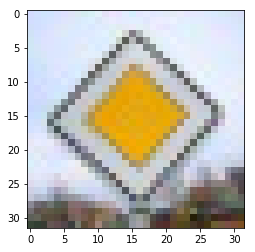

In [64]:
img = mpimg.imread('test_images/' + imageNames[0])
plt.imshow(img)

When putting the priority road sign displayed above in the CNN, the feature maps show an interesting behaviour. The first layer recognizes the very basic outter shape of the sign, whereas the second and third layer recognize more advanced features like the inner shape and specific edges.